# LGBIO2060 - Exercise session 1
# Sequential probability ratio test and urgency gating

After this first tutorial, you should be able to understand and explain the likelihood function as well as the drift diffusion model. You should also be able to implement the DDM and to discuss the different stopping criteria as well as a the speed accuracy tradeoff.

## Imports and helper functions
**Please execute the cell(s) below to initialize the notebook environment.**

In [2]:
#Import the libraries 
import numpy as np #for the math stuff
import matplotlib.pyplot as plt #for the plot handling
from scipy.stats import norm


In [3]:
def plot_my_gaussian(x,px):
  """
  This function plots a Gaussian distribution

  Inputs : x (numpy array) along which we want to represent the distribution
           px(numpy array) values taken by the distribution
  """

  fig, ax=plt.subplots()
  ax.plot(x,px,'C1',LineWidth=2,label='Estimated state')
  ax.axvline(x[px.argmax()],label='Latent state')
  ax.legend()
  ax.set_ylabel('Probability')
  ax.set_xlabel('Value')

  return ax

___
# Part 1 : Gaussian distribution - Inferring the world through sensory input

*Click [here](https://github.com/fblondiaux/LGBIO2060-2020/blob/master/WorkFromHomeText/TP1-Part1.txt) for more context*.


We want to observe a latent state (ie. the real state that we cannot exactly know) through our senses that are noisy. Therefore, this latent state will be observed through some noise. We will assume that the observed state can be modelled by a Gaussian distribution whose mean is the real value of the latent state (unknown) and whose variance characterises the amount of noise present in the sensory system. We can therefore write that the observation $y$ follows a Gaussian distribution of mean $\mu$ and standard deviation $\sigma$ :

\\

$$
y\sim\mathcal{N}\left(\mu,\, \sigma^2\right)
$$

\\


As a reminder, a Gaussian distribution is characterised by the following probability density function : \\


$$\mathcal{N}\left(\mu,\sigma^2\right) = \frac{1}{\sqrt{2\pi \sigma^2}}\exp\left(\frac{-\left(x-\mu\right)^2}{2\sigma^2}\right)$$

**Exercise 1**

Implement a function that generates a gaussian distribution given its parameters and the domain where it will be evaluated, $x_{vector}$


Text(0.5, 0, 'Position')

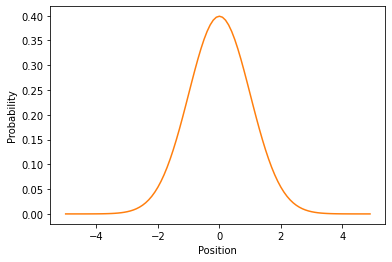

In [4]:
def my_gaussian(x_vector,mu,sigma):
  """
  Author: Antoine de Comite 
  This function computes the gaussian distribution characterised by mu & sigma on the set x_vector
  
  Inputs : x_vector (numpy array) the set over which you want to compute the gaussian distribution
           mu (double) mean value of the gaussian distribution
           sigma (double) standard deviation of the gaussian distribution
  Outputs: px (numpy array) is the gaussian distribution evaluated over x_vector
  """
  
  px = 1/(np.sqrt(2*np.pi*sigma**2)) *np.exp((-(x_vector-mu)**2)/(2*sigma**2))
  return px

# Test your function on a gaussian of mean 0, variance 1 that you compute over
# the set [-5,5]. Create a graphical representation of your distribution

x_vector = np.arange(-5,5,0.1)
mu = 0
sigma = 1 
px = my_gaussian(x_vector,mu,sigma)

fig, ax = plt.subplots()
ax.plot(x_vector,px,'C1')
ax.set_ylabel('Probability')
ax.set_xlabel('Position')

Click [here](https://github.com/fblondiaux/LGBIO2060-2020/blob/master/Solutions/Exercise1Solution) for solution.

*Example output:*


<img alt='Solution hint' align='left' width=413 height=300 src=https://raw.githubusercontent.com/fblondiaux/LGBIO2060-2020/master/Solutions/TP1_Ex1.png>


Use the widget herebelow to investigate the impact of the mean and standard deviation on the shape of the gaussian distribution (be patient, the widget updates every few seconds). 
Your function of exercise 1 should be working for this widget to work.


**Make sure to execute the cell before playing with the widget**

In [5]:
#@title

x = np.arange(-10,11,0.1)

import ipywidgets as widgets

def refresh(mu=1,sigma=1):
  gaussian = my_gaussian(x,mu,sigma)

  ax = plot_my_gaussian(x,gaussian)
  plt.show()

style = {'description_width' : 'initial'}

_ = widgets.interact(refresh,
    mu = widgets.FloatSlider(value=2, min=-7, max=7, steps=0.5, description="mu:", style = style),
    sigma = widgets.FloatSlider(value=0.5, min=0.5, max=10, steps=0.5, description="sigma",style=style),
)

interactive(children=(FloatSlider(value=2.0, description='mu:', max=7.0, min=-7.0, style=SliderStyle(descripti…

**Summary**

The gaussian distribution can be very useful in many situations and fields. In this tutorial, it is used to model the noise present in our sensory inputs. Therefore, the observations of our environment that we make are drawn from a Gaussian distribution that characterizes our sensory inputs. This variability we observe in the way we infer the external world is also present in nature. Indeed, there is much variability in the of size of living tissue (length, height, skin area, weight), the length of inert appendages (hair, claws, nails, teeth), in the behaviour of animals and humans...

Let's see how we can deal with this variability to perform decision making ! 


---

# Part 2 : Sequential probability ratio test (SPRT) - Decision making

*Click [here](https://github.com/fblondiaux/LGBIO2060-2020/blob/master/WorkFromHomeText/TPLGBIO2060.pdf) for more explanations*

Let us consider a toy experiment. On each trial $i$, the subject is shown a dot moving on a screen. The horizontal velocity, $v_i$, is generated by a probability distribution, which we know to be either: 


$$
\\
\begin{eqnarray}
p_L &=& \mathcal{N}\left(-1,\sigma^2\right)\\
&& \textrm{or}\\
p_R &=& \mathcal{N}\left(+1,\sigma^2\right)\\
\end{eqnarray}
$$

By looking at a large number of dots (so by doing the experiment for a long time), we want to determine which distribution amongst $p_L$ and $p_R$ is the true data generating one. The decision process is based on the time-evolution of the log likelihood ratio between these two hypotheses. 
For both alternatives, we will define the likelihood function that will quantify how probable it is that the data point $x_i$ comes from a each distribution. For a given occurence of the point $x_i$, the two likelihood functions will be defined by $p_L\left(x_i|z=0\right)$ and $p_R\left(x_i|z=1\right)$, which are two gaussian distributions and where $z$ is a binary variable used to identify which distribution is the true one.


Using the following gaussian observations models for the two alternative distributions

$$\begin{eqnarray}
p_L\left(x|z=0\right) & = & \mathcal{N}\left(\mu_L,\sigma_L^2\right)\\
p_R\left(x|z=1\right) & = & \mathcal{N}\left(\mu_R,\sigma_R^2\right)\\
\end{eqnarray}
$$

and the definition of the log-likelihood ratio $\Lambda_i = \dfrac{\log\left(p_L\right)}{\log\left(p_R\right)}$

**Compute the expression of $\Lambda_i$, the log-likelihood ratio at iteration $i$** 

Click [here](https://github.com/fblondiaux/LGBIO2060-2020/blob/master/Solutions/Tuto1SolLikelihood) for solution


Using the expression of the log-likelihood ratio you just computed, implement the function *compute_SPRT_fixedtime* whose signature is given below. This function implements the drift diffusion model. 


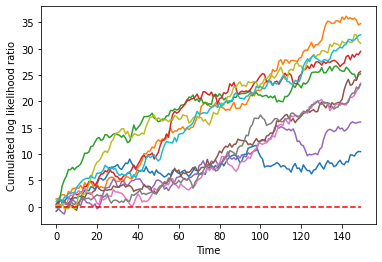

In [6]:
def compute_SPRT_fixedtime(sigma,true_dist,stopTime):
    """
    This function performs the sequential probability ratio test using the fixed time stopping criterion
    Authors : Florence Blondiaux & Antoine de Comite 

    Inputs :  sigma (float) is the standard deviation of both distribution
              true_dist (int) is the true distribution 0 or 1
              stopTime (int) number of samples to take before stopping
    Output : evidence_history (numpy vector) containing the history of evidence
            decision (integer) 0 or 1 depending on the most probable decision at the end of trial
    """

    ##########################
    ##### Your code here #####
    ##########################
    muL = -1.0; muR = 1.0
   
    # Generate a random sequence of data
    pL = norm(loc=muL,scale=sigma)
    pR = norm(loc=muR,scale=sigma)
    if true_dist == 1:
      data = pR.rvs(size=stopTime)
    else:
      data = pL.rvs(size=stopTime)

    evidence_history = []
    current_evidence = 0.0
    for i in range(stopTime):
        ll_ratio = np.log(sigma/sigma) + 0.5*(data[i]-muL)**2/(sigma**2) - 0.5*(data[i]-muR)**2/(sigma**2)
        evidence_history.append(ll_ratio+current_evidence)
        current_evidence = evidence_history[-1]
    evidence_history = np.array(evidence_history)
    if evidence_history[-1]>0:
        decision = 1
    elif evidence_history[-1]<0:
        decision = 0
    else:
        decision = np.random.randint(2)
    return evidence_history,decision





In [ ]:
# Simulate 10 trials and plot their evidence history.
# For the example of solution, the true distribution was pR and sigma was set to 3.5


def simulate_and_plot_SPRT_fixedtime(nb_trials, sigma=3.5, true_dist = 1,stopTime = 150 ):
    '''
    Simulate and plot a SPRT for a fixed amount of time given a std.
    Authors : Florence Blondiaux & Antoine de Comite 
    Input: nb_trials: Number of simulations to run per stopping time
          sigma (float) is the standard deviation of both distribution
          true_dist (int) is the true distribution 0 or 1
          stopTime (int) number of samples to take before stopping

    '''
    ##########################
    ##### Your code here #####
    ##########################

np.random.seed(100) 
simulate_and_plot_SPRT_fixedtime(10)

Click [here](https://github.com/fblondiaux/LGBIO2060-2020/blob/master/Solutions/Exercise2Solution) for solution

*Example output:*

<img alt='Solution hint' align='left' width=573 height=416 src=https://raw.githubusercontent.com/fblondiaux/LGBIO2060-2020/master/Solutions/TP1_Ex2.png>


Explore different values for *sigma* and *stop_time* using the following widget.

**Make sure to execute this cell to enable the widget**

In [7]:
#@title
np.random.seed(100)
num_sample = 10

@widgets.interact
def plot(sigma=(0.05, 10.0, 0.05), stop_time=(5, 500, 5),true_dist= [0,1]):
  simulate_and_plot_SPRT_fixedtime(num_sample,sigma,true_dist,stop_time)

interactive(children=(FloatSlider(value=5.0, description='sigma', max=10.0, min=0.05, step=0.05), IntSlider(va…



In this first example, the decision is made after a given time (that may be very long); this is not always the optimal way to stop the drift diffusion model. In the next section, we will investigate another stopping criterion.

# Part 3 : Drift diffusion model with fixed threshold
Click [here](https://github.com/fblondiaux/LGBIO2060-2020/blob/master/WorkFromHomeText/TP1-Part3.txt) for more explanations. 


The thresholding stopping rule define a desire error rate and will continue making measurements until that error rate is reached. Experimental evidence suggested that evidence accumulation and thresholding stopping strategy happens at neuronal level (see [this article](https://www.annualreviews.org/doi/abs/10.1146/annurev.neuro.29.051605.113038?journalCode=neuro) for further reading). In this exercise, we will use thresholding as our stopping rule and observe the behavior of the DDM. 


Mathematically speaking, the threshold is defined based on the likelihood ratio that has been computed before. We define the error rate $\alpha$ that we want to accept. Based on the properties of probability, we can define the following thresholds for our decision making process.

$$
\begin{eqnarray}
th_L = \log \dfrac{\alpha}{1-\alpha} & = & -th_R\\
th_R = \log \dfrac{1-\alpha}{\alpha} & = & -th_L
\end{eqnarray}
$$

The drift diffusion process will be stopped as the log-likelihood ratio cross one of these thresholds.

Implement the function *threshold_DDM* whose signature is given below :



In [8]:
def compute_SPRT_threshold(sigma,true_dist,alpha):
    """
    This function performs the sequential probability ratio test using the threshold stopping criterion
    Authors : Florence Blondiaux & Antoine de Comite 

    Inputs :  sigma (float) is the standard deviation of both distribution
              true_dist (int) is the true distribution 0 or 1
              alpha (int): Desired  error rate that we want to accept.
    Output : evidence_history (numpy vector) containing the history of evidence
            decision (integer) 0 or 1 depending on the most probable decision at the end of trial
    """


    ##########################
    ##### Your code here #####
    ##########################
    muL = -1.0; muR = 1.0
    pL = norm(loc=muL,scale=sigma)
    pR = norm(loc=muR,scale=sigma)
    evidence_history = []
    current_evidence = 0.0
    threshold_reached = False
    # Definition of the threshold level - Because of the logarithmic fct we can use only the absolute value
    threshold = np.log(alpha/(1-alpha))
    while not threshold_reached:
        if true_dist == 1:
            data = pR.rvs()
        else:
            data = pL.rvs()
        ll_ratio = np.log(sigma/sigma) - 0.5*(data-muR)**2/(sigma**2) + 0.5*(data-muL)**2/(sigma**2)
        evidence_history.append(ll_ratio+current_evidence)
        current_evidence = evidence_history[-1]
        if abs(current_evidence)> abs(threshold):
            threshold_reached = True


    evidence_history = np.array(evidence_history)
    if evidence_history[-1]>0:
        decision = 1
    elif evidence_history[-1]<0:
        decision = 0
    else:
        decision = np.random.randint(2)
    
    return evidence_history,decision
    
    return evidence_history,decision

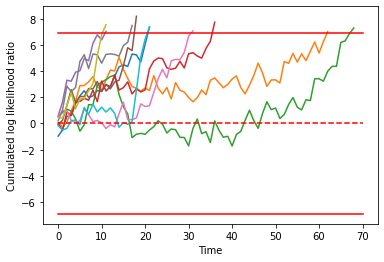

In [9]:
def simulate_and_plot_SPRT_threshold(nb_trials, sigma = 2.9, true_dist = 1, alpha = 1e-3):
    '''
    Simulate and plot a SPRT for a fixed amount of time given a std.
    Authors : Florence Blondiaux & Antoine de Comite 
    Input: nb_trials: Number of simulations to run
           sigma (float) is the standard deviation of both distribution
           true_dist (int) is the true distribution 0 or 1
           alpha (int): Desired  error rate that we want to accept.
    '''

    ##########################
    ##### Your code here #####
    ##########################
    for i in range(nb_trials):
        evidence, decision = compute_SPRT_threshold(sigma,true_dist,alpha)
        plt.plot(evidence)
    plt.xlabel("Time")
    plt.ylabel("Cumulated log likelihood ratio")
    axes = plt.gca()
    _, xmax = axes.get_xlim()
    threshold = np.log(alpha/(1-alpha))
    plt.plot(np.zeros(int(xmax)),"r--")
    plt.plot(np.zeros(int(xmax))+threshold,"r")
    plt.plot(np.zeros(int(xmax))-threshold,"r")

np.random.seed(100) 
simulate_and_plot_SPRT_threshold(10, sigma = 2.9, true_dist = 1, alpha = 1e-3)

Click [here](https://github.com/fblondiaux/LGBIO2060-2020/blob/master/Solutions/Exercise3Solution) for solution

*Example output:*

<img alt='Solution hint' align='left' width=573 height=416 src=https://raw.githubusercontent.com/fblondiaux/LGBIO2060-2020/master/Solutions/TP1_Ex3.png>

Explore different values for sigma and alpha using the following widget.

**Make sure your execute this cell to enable the widget**
The error rate $\alpha$ is expressed in percentage

In [ ]:
#@title

#@markdown Make sure you execute this cell to enable the widget!


#@markdown The error rate alpha is in percent.
np.random.seed(100)
num_sample = 10

@widgets.interact
def plot(sigma=(0.05, 10.0, 0.05), alpha=(0.1, 10, 0.1),true_dist= [0,1]):
  simulate_and_plot_SPRT_threshold(num_sample,sigma,true_dist,alpha*1e-2)

# Part 4 : Accuracy vs. Threshold

Click [here](https://github.com/fblondiaux/LGBIO2060-2020/blob/master/WorkFromHomeText/TP1-Part4.txt) for more explanations.

The faster you make a decision, the lower your accuracy is. This phenomenon is known as the **speed/accuracy tradeoff**. 
To illustrate the speed/accuracy tradeoff under thresholding stopping rule, let us run some simulations with different thresholds and look at how average decision speed (1/length) changes with average decision accuracy.

Complete the function simulate_accuracy_vs_threshold to simulate and compute accuracies vs. average decision lengths for a list of error thresholds. You will need to supply code to calculate average decision "speed" from the lengts of trials. You should also calculate the overall accuracy across these trials.

We have set up a list of error thresholds. Run repeated simulations and collect average accuracy with average length for each error rate in this list.

In [ ]:
def simulate_accuracy_vs_threshold(sigma, alpha_list, num_sample):
  """Calculate the average decision accuracy vs. average decision speed by
  running repeated SPRT simulations with thresholding stopping rule for each
  threshold.
  Args:
      sigma (float): standard deviation for observation model
      alpha_list (list-like object): a list of error rates alpha to run
                                          over
      num_sample (int): number of simulations to run
  Returns:
      accuracy_list: a list of average accuracies corresponding to input
                      `threshold_list`
      decision_speed_list: a list of average decision speeds
  """
    ##########################
    ##### Your code here #####
    ##########################

  return accuracy_list, decision_speed_list


In [ ]:
def simulate_and_plot_accuracy_vs_threshold(sigma, threshold_list, num_sample):
  """Simulate and plot a SPRT for a set of thresholds given a std.

  Args:
    sigma (float): Standard deviation of the observations.
    alpha_list (float): List of thresholds for making a decision.
    num_sample (int): The number of samples to plot.
  """
    ##########################
    ##### Your code here #####
    ##########################

np.random.seed(100)
sigma = 3.75
num_sample = 200
alpha_list = np.linspace(0.001,0.5, 9) 
simulate_and_plot_accuracy_vs_threshold(sigma, alpha_list, num_sample)

Click [here](https://github.com/fblondiaux/LGBIO2060-2020/blob/master/Solutions/Exercise4Solution) for solution

*Example output:*

<img alt='Solution hint' align='left' width=573 height=416 src=https://raw.githubusercontent.com/fblondiaux/LGBIO2060-2020/master/Solutions/TP1_Ex4.png>